In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd

In [2]:
height = 64
width = 64
desired_frames = 30
channels = 3

In [7]:
train_dir = '/content/drive/MyDrive/ucf101_top5/train'
test_dir = '/content/drive/MyDrive/ucf101_top5/test'

In [8]:
train_csv_path = '/content/drive/MyDrive/ucf101_top5/train.csv'
train_df = pd.read_csv(train_csv_path)

In [9]:
test_csv_path = '/content/drive/MyDrive/ucf101_top5/test.csv'
test_df = pd.read_csv(test_csv_path)

In [10]:
train_videos = []
train_labels = []
test_videos = []
test_labels = []

In [11]:
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (height, width))
        frame = frame / 255.0
        frames.append(frame)
    cap.release()
    if len(frames) < desired_frames:
        frames.extend([np.zeros((height, width, channels)) for _ in range(desired_frames - len(frames))])
    elif len(frames) > desired_frames:
        frames = frames[:desired_frames]
    return frames

In [12]:
label_map = {}
next_label = 0
for index, row in train_df.iterrows():
    video_path = os.path.join(train_dir, row['video_name'])
    frames = preprocess_video(video_path)
    train_videos.append(frames)
    label = row['tag']
    if label not in label_map:
        label_map[label] = next_label
        next_label += 1
    train_labels.append(label_map[label])

In [13]:
for index, row in test_df.iterrows():
    video_path = os.path.join(test_dir, row['video_name'])
    frames = preprocess_video(video_path)
    test_videos.append(frames)
    label = row['tag']
    if label not in label_map:
        label_map[label] = next_label
        next_label += 1
    test_labels.append(label_map[label])

In [14]:
train_videos = np.array(train_videos)
train_labels = np.array(train_labels)
test_videos = np.array(test_videos)
test_labels = np.array(test_labels)

In [15]:
model = Sequential([
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=(desired_frames, height, width, channels)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(128, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(256, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(train_videos, train_labels, epochs=10, validation_data=(test_videos, test_labels))

Epoch 1/10
19/19 [==============================] - 20s 533ms/step - loss: 1.8192 - accuracy: 0.2862 - val_loss: 1.3394 - val_accuracy: 0.4241
Epoch 2/10
19/19 [==============================] - 7s 377ms/step - loss: 1.0105 - accuracy: 0.6364 - val_loss: 1.0852 - val_accuracy: 0.5000
Epoch 3/10
19/19 [==============================] - 7s 353ms/step - loss: 0.5620 - accuracy: 0.7845 - val_loss: 0.8748 - val_accuracy: 0.6205
Epoch 4/10
19/19 [==============================] - 7s 361ms/step - loss: 0.3144 - accuracy: 0.8788 - val_loss: 0.8564 - val_accuracy: 0.6562
Epoch 5/10
19/19 [==============================] - 7s 388ms/step - loss: 0.2504 - accuracy: 0.9091 - val_loss: 1.0988 - val_accuracy: 0.6071
Epoch 6/10
19/19 [==============================] - 7s 367ms/step - loss: 0.1633 - accuracy: 0.9394 - val_loss: 0.7529 - val_accuracy: 0.6786
Epoch 7/10
19/19 [==============================] - 7s 374ms/step - loss: 0.0736 - accuracy: 0.9747 - val_loss: 0.7454 - val_accuracy: 0.7500
Epoch

In [18]:
test_loss, test_acc = model.evaluate(test_videos, test_labels)
print(f'Test accuracy: {test_acc}')

7/7 [==============================] - 1s 128ms/step - loss: 0.9840 - accuracy: 0.6875
Test accuracy: 0.6875


In [19]:
predictions = model.predict(test_videos)

7/7 [==============================] - 1s 120ms/step


In [20]:
reverse_label_map = {v: k for k, v in label_map.items()}

predicted_labels = np.argmax(predictions, axis=1)

for i in range(len(test_labels)):
    predicted_label_name = reverse_label_map[predicted_labels[i]]
    true_label_name = reverse_label_map[test_labels[i]]
    print(f"Predicted label: {predicted_label_name}, True label: {true_label_name}")


Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: TennisSwing, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: TennisSwing, True label: CricketShot
Predicted label: TennisSwing, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: TennisSwing, True label: CricketShot
Predicted label: TennisSwing

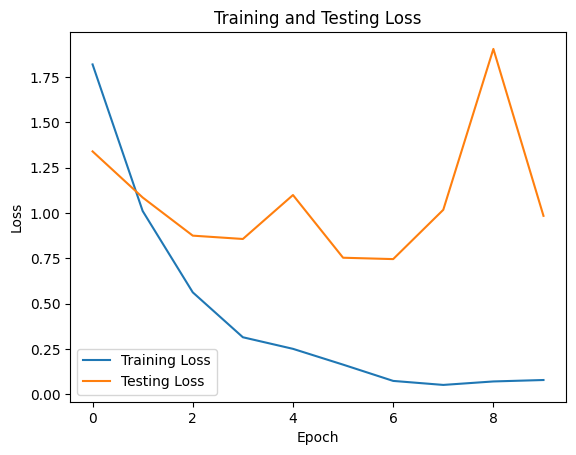

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

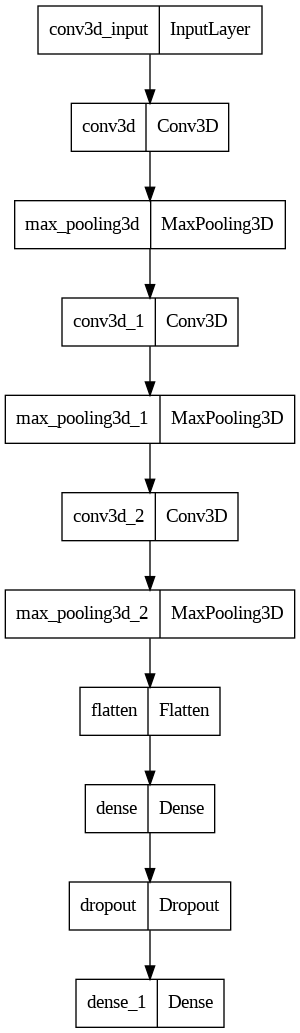

In [22]:
from keras.utils import plot_model
plot_model(model, to_file = 'cnn_video.png')